# Antisocial Final Project

In [108]:
import tqdm
# ^^^ pyforest auto-imports - don't write above this line
# imports
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
import seaborn as sns
import csv
import os
import glob
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pprint
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## Datasets

In [109]:
# load shared articles dataset
articles_df = pd.read_csv('./archive/shared_articles.csv')
print("number of datapoints: ", articles_df.shape[0])
print("number of columns: ", articles_df.shape[0])
print("columns:")
pprint.pprint(list(articles_df.columns))

number of datapoints:  3122
number of columns:  3122
columns:
['timestamp',
 'eventType',
 'contentId',
 'authorPersonId',
 'authorSessionId',
 'authorUserAgent',
 'authorRegion',
 'authorCountry',
 'contentType',
 'url',
 'title',
 'text',
 'lang']


In [110]:
# visualizing a few columns
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [111]:
# load user interactions dataset
interactions_df = pd.read_csv('./archive/users_interactions.csv')
print("number of datapoints: ", interactions_df.shape[0])
print("number of columns: ", interactions_df.shape[0])
print("columns:")
pprint.pprint(list(interactions_df.columns))

number of datapoints:  72312
number of columns:  72312
columns:
['timestamp',
 'eventType',
 'contentId',
 'personId',
 'sessionId',
 'userAgent',
 'userRegion',
 'userCountry']


In [112]:
# visualizing a few columns
interactions_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [243]:
# load user friends dataset
friends_df = pd.read_csv('./archive/en_user_friends.csv')
print("number of datapoints: ", friends_df.shape[0])
print("number of columns: ", friends_df.shape[0])
print("columns:")
pprint.pprint(list(friends_df.columns))

number of datapoints:  1644
number of columns:  1644
columns:
['personId', 'friends']


## Exploratory Data Analysis

In [32]:
## some utility functions to plot graphs

# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

##### For the shared article dataset

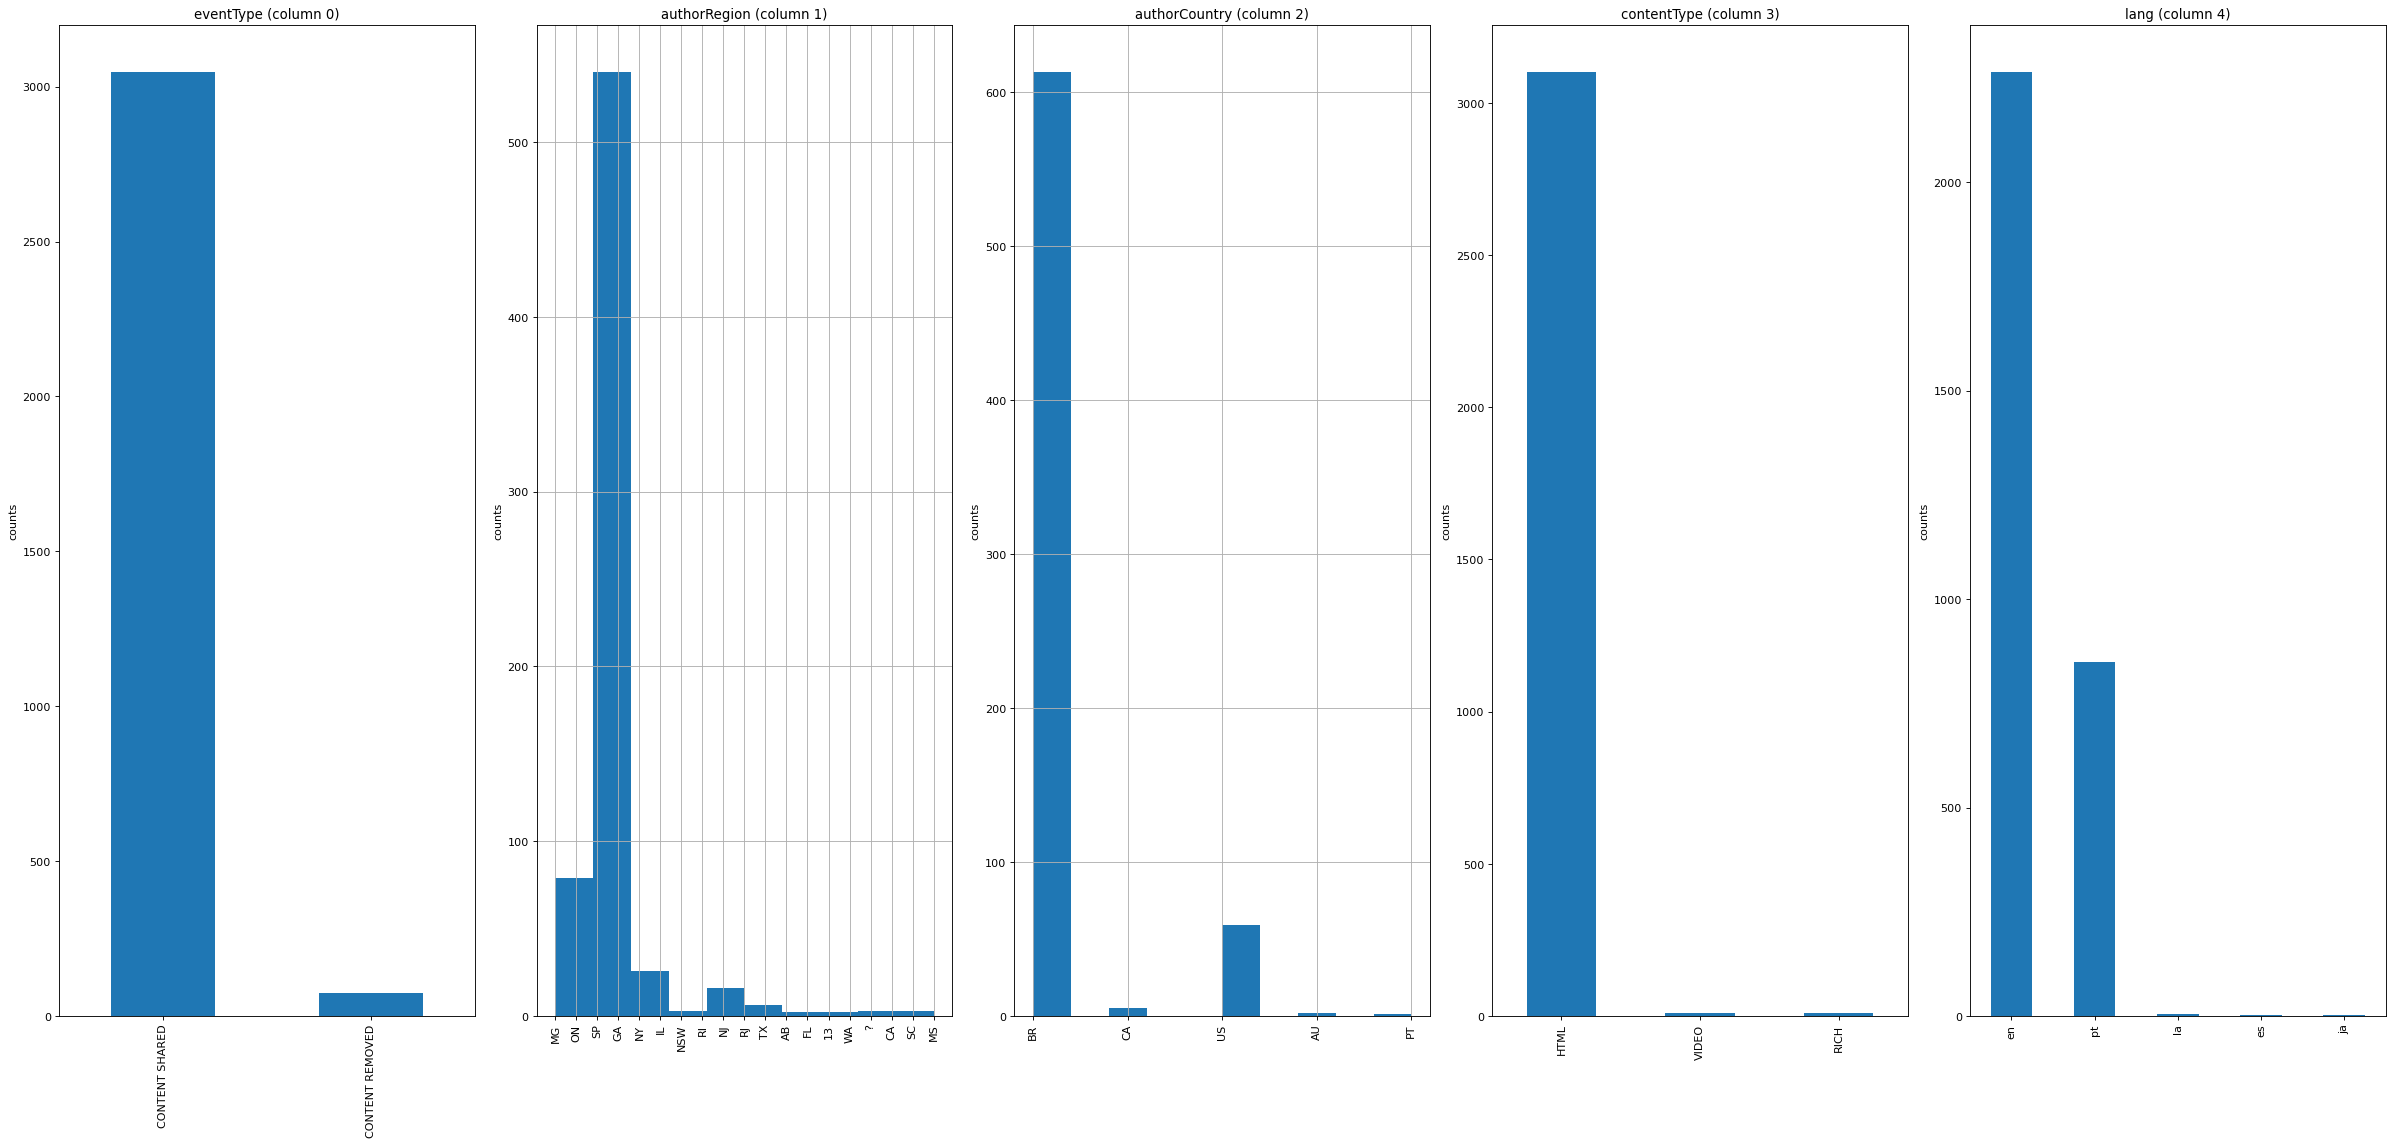

In [34]:
plotPerColumnDistribution(articles_df, 10, 5)

##### For the interactions dataset

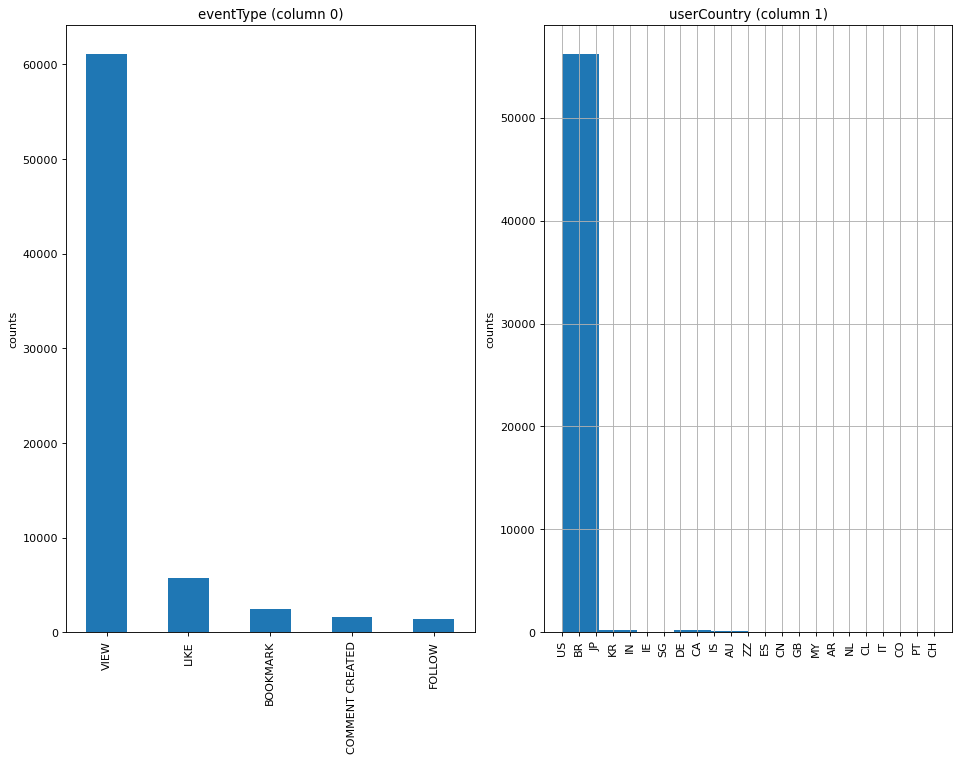

In [38]:
plotPerColumnDistribution(interactions_df, 10, 5)

In [40]:
print('Distinct articles: \t%d' % len(interactions_df['contentId'].unique()))
print('Distinct users: \t%d' % len(interactions_df['personId'].unique()))
print('Distinct user sessions: \t%d' % len(interactions_df['sessionId'].unique()))

Distinct articles: 	2987
Distinct users: 	1895
Distinct user sessions: 	28740


### Conclusion of EDA:
For the purposes of this project, we would be working with the interactions dataset which has ~73k points, ~3k articles and ~2k users.\
\
We can see that various actions indicates various levels of interactions of user with the article. The interactions can be rated in the following order from most strong positive interaction to least:
1. Follow
2. Bookmark
3. Like
4. Comment Created
5. View

In [195]:
articles_df_en = articles_df.loc[articles_df['lang']=='en']
content_ids_en = set(articles_df_en['contentId'].values)
interactions_df_en = interactions_df.loc[interactions_df['contentId'].isin(content_ids_en)].reset_index()

### Utility Datasets

In [244]:
from collections import defaultdict
usersPerItem = defaultdict(set) 
itemsPerUser = defaultdict(set)
userItemDict = {}
userItemInteractionTypeDict = {}
itemUserInteractionTypeDict = {}
friendsPerUser = {}


for i, row in tqdm(interactions_df_en.iterrows()):
    user = row['personId']
    item = row['contentId']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    userItemDict[(user, item)] = row
    userItemInteractionTypeDict[(user, item)] = row['eventType']
    itemUserInteractionTypeDict[(item, user)] = row['eventType']

for i, row in tqdm(friends_df.iterrows()):
    friendsPerUser[row['personId']] = set(eval(row['friends']))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [245]:
friendItemsPerUser = defaultdict(set)
for u, friends in tqdm(friendsPerUser.items()):
    for friend in friends:
        friendItemsPerUser[u] = friendItemsPerUser[u].union(itemsPerUser[friend])

  0%|          | 0/1644 [00:00<?, ?it/s]

### Recommendation Systems

##### Generate random recommendations

In [246]:
def getRandomArticles(u, n):
    itemScoreDict = defaultdict(list)
    random_n_articles = random.sample(usersPerItem.keys(), n)
    for item in random_n_articles:
        similarities = itemItemSimilarity(item, usersPerItem.keys())
        for sim, item in similarities:
            itemScoreDict[item].append(sim)
    itemScoreTuple = []
    for k, v in itemScoreDict.items():
        itemScoreTuple.append((sum(v)/len(v), k))
    itemScoreTuple.sort()
    return itemScoreTuple[:n]

##### generate opposite recommendations considering item-item similarity scores and friends list

In [248]:
# utility function to calculate jaccard similarity
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [249]:
def itemItemSimilarity(i, items):
    similarities = []
    for item in items:
        if item!=i:
            sim = Jaccard(usersPerItem[i], usersPerItem[item])
            if sim!=0:
                similarities.append((sim,item))
    return similarities

In [250]:
def getRecommendedArticles(u):
    # get least similar friends:
    itemScoreDict = defaultdict(list)
    for item in itemsPerUser[u]:
        similarities = itemItemSimilarity(item, usersPerItem.keys())
        for sim, item in similarities:
            itemScoreDict[item].append(sim)
    itemScoreTuples = []
    for k, v in itemScoreDict.items():
        itemScoreTuples.append((sum(v)/len(v), k))
    itemScoreTuples.sort()
    return itemScoreTuples

In [332]:
def filterByFriends(u, itemScoreTuples, n):
    filteredList = []
    for score, item in itemScoreTuples:
        if item in friendItemsPerUser[u]:
            filteredList.append((score, item))
    return filteredList[:n]

In [255]:
# test
# getRandomArticles(115141794465366279, 10)

## Chrome extension simulation

In [358]:
# Simulation of content type (aka chrome extension)
import ipywidgets as widgets
class widget:
    def __init__(self):
        # main variable
        self.content_selection = 0 # default
        
        # enable widget only once
        self.flag = 1
    
        # Define the options for the radio buttons
        self.options = {0:'Random', 1:'Burst my Bubble'}
        

        # Create the radio buttons widget
        self.radio_buttons = widgets.RadioButtons(
            options=options,
            description='What type of content do you want to see?',
            disabled=False
        ) 
        
        # Define a function to be called when a radio button is selected
        def _on_radio_button_change(change):
            if change.new=='Random':
                self.content_selection=0
            else:
                self.content_selection=1
        
        # Attach the function to the radio buttons widget
        self.radio_buttons.observe(_on_radio_button_change, names='value')
    
    # Display the radio buttons widget
    def enable_widget(self):
        if self.flag:
            display(self.radio_buttons)
        self.flag = 0
        
    # recommend article
    def getTopNArticles(self, user, n):
        articles = None
        if self.content_selection==0:
            print('in random')
            articles = getRandomArticles(user, n)
        else:
            print('in bursting the bubble')
            tuples = getRecommendedArticles(user)
            articles =  filterByFriends(user, tuples, n)
        articles = [('contentId\t', 'simlarity score')]+[(v, k) for k, v in articles]
        pprint.pprint(articles)
    
    # get state
    def get_state(self):
        return 'Random' if self.content_selection==0 else 'Bursting my Bubble'

In [359]:
widget = widget()

In [360]:
widget.enable_widget()

RadioButtons(description='What type of content do you want to see?', options=('Random', 'Burst my Bubble'), va…

In [361]:
widget.get_state()

'Random'

In [362]:
user = 115141794465366279
count = 10

In [363]:
widget.getTopNArticles(user, count)

in random
[('contentId\t', 'simlarity score'),
 (1469580151036142903, 0.009261867150027508),
 (-4029704725707465084, 0.010933710360709637),
 (-6542996094878850014, 0.014540781089910904),
 (-4503975842879662368, 0.014632412294258212),
 (-5488842573681626972, 0.01650261260210384),
 (-4333957157636611418, 0.017224776992975928),
 (-6623581327558800021, 0.01729325447635307),
 (-8627051188605351707, 0.01847125667833636),
 (-14569272361926584, 0.02016579796475552),
 (-5848514031542611523, 0.020833333333333332)]


In [364]:
widget.get_state()

'Bursting my Bubble'

In [365]:
widget.getTopNArticles(user, count)

in bursting the bubble
[('contentId\t', 'simlarity score'),
 (4774970687540378081, 0.009708737864077669),
 (-7809508238092432842, 0.009900990099009901),
 (7255021292858609470, 0.01),
 (-4293262855938209141, 0.01020408163265306),
 (-8669770849634489893, 0.010309278350515464),
 (-5361115220834660562, 0.010526315789473684),
 (4785499183287168509, 0.010526315789473684),
 (4915137112517573184, 0.010526315789473684),
 (5468598741732935699, 0.010638297872340425),
 (8736111317960965711, 0.010638297872340425)]
